### Table of Contents
* [Instructions](#instructions)
* [Part A: Predicting percentage change in multiple bacteria populations given their spreading factor](#partA)
    * [Q1: Data Visualization](#partAQ1)
    * [Q2: Use k-fold cross validation along with Bootstraps to find the best degree](#partAQ2)
    * [Q3: Improving model consistency](#partAQ3)
* [Part B: Racial bias in machine learning systems](#partB)
    * [Q1: Setting up the problem and understanding the data](#partBQ1)
    * [Q2: Baseline model fitting](#partBQ2)
    * [Q3: 'Race'less model fitting](#partBQ3)
    * [Q4: Receiver Operating Characteristic curve](#partBQ4)    
    * [Q5: Decision Tree](#partBQ5)    
* [Part C: Come up with a better model](#partC)

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

In [2]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from prettytable import PrettyTable
import warnings
import pydot
warnings.filterwarnings('ignore')
sns.set()

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<b> Question 1:   Data Visualization [3 points]</b> <a class="anchor" id="partAQ1"></a>
    <br /><br />
**1.1** [2 pts] Generate a scatter plot of the data points in the `bacteria_train.csv` 
file with the `Spreading factor` on the $X$-axis and the `Percentage` 
change on the $Y$-axis. Make sure you clearly label the $x$ and $y$ axes and include proper title. 
<br /><br />
**1.2** [1 pts] Based on the graph, is there any discernable relationship between 
the spreading factor and percentage change in population?
    
</div>


### Solutions

<h4>1.1</h4> <b>Generate a scatter plot of the data points in the bacteria_train.csv file with the Spreading factor on the  𝑋 -axis and the Percentage change on the  𝑌 -axis. Make sure you clearly label the  𝑥  and  𝑦  axes and include proper title.<b>

In [3]:
df_train = pd.read_csv("data/bacteria_train.csv")
df_test = pd.read_csv("data/bacteria_test.csv")

x_train = df_train[['Spreading_factor']].values
y_train = df_train.Perc_population.values

x_test = df_test[['Spreading_factor']].values
y_test = df_test.Perc_population.values

df_train.head()

,Perc_population,Spreading_factor
0,1.535,0.190708
1,5.555,0.326928
2,-0.277,-0.459699
3,1.724,-0.193013
4,-0.550,-0.835745


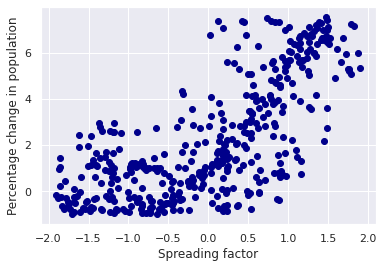

In [4]:
plt.scatter(x_train,y_train,color='darkblue')
plt.xlabel("Spreading factor")
plt.ylabel("Percentage change in population")
plt.show()

<h4>1.2</h4> <b>Based on the graph, is there any discernable relationship between the spreading factor and percentage change in population?<b>

Though non-linear, there appears to be some relationship between the spreading factor and population change. As the spreading factor increases the population of the bacteria is also increasing. It seems to be somewhere between quatric and cubic.

<h4>2.1</h4> <b>Use bootstrapping to test the robustness of your estimation of the degree chosen.<b>

In [5]:
# Define the variables
numboot = 100
max_deg = 30

In [6]:
# Bootstrap first & then find the best degree
deg_list = []
for i in range(numboot):
    newdf = df_train.sample(frac=1,replace=True)
    mse_list = []
    for j in range(1,max_deg+1):
        degree = j
        x_train = newdf[['Spreading_factor']]
        x_poly_train = PolynomialFeatures(degree).fit_transform(x_train)
        y_train = newdf.Perc_population
        linreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(linreg, 
                                   x_poly_train, 
                                   y_train, cv=10, 
                                   scoring="neg_mean_squared_error",
                                   return_train_score=True)
        mean_mse = np.mean(-mse_score['test_score'])
        mse_list.append(mean_mse)
    deg_list.append(mse_list.index(min(mse_list))+1)

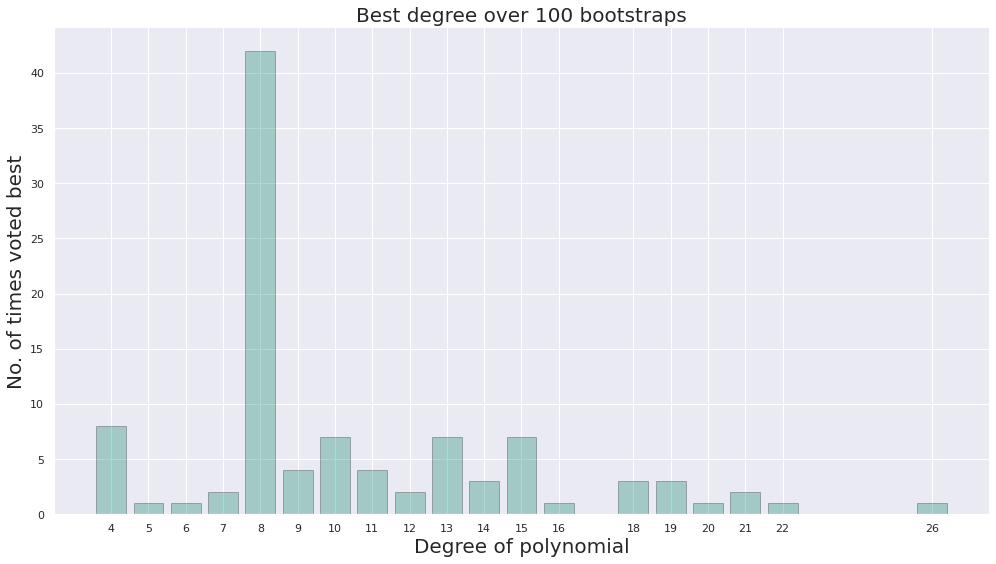

In [7]:
from collections import Counter
c = Counter(deg_list)

fig,ax = plt.subplots(figsize=(14,8))
ax.bar(c.keys(),c.values(),color = '#007D66',alpha=0.3,edgecolor='k')
ax.set_xticks(sorted(c.keys()));
ax.set_xlabel(r'Degree of polynomial', fontsize=20)
ax.set_ylabel('No. of times voted best', fontsize=20)
ax.set_title(f'Best degree over {numboot} bootstraps',fontsize=20)
sns.despine()
plt.tight_layout()

<h4>2.2</h4> <b>What are your observations?<b>

<b> a) Why do you see so much variance in the best_degree over the bootstraps?<b>

The variance could be a result of slight change in the data for each bootstrap.The stochasticity in the choice of bootstraps may also be the reason.

<b> b) What will you choose as your best_degree for the test set?<b>

The degree with the highest frequency/ number of times voted the best will be the bset degree.

<h4> 2.3 </h4> <b> Fitting the best model on the test data <b>

In [8]:
# Select the best degree from the above exercise
best_deg = 8

In [9]:
# Compute the polynomial features
x_poly_train = PolynomialFeatures(best_deg).fit_transform(x_train)
x_poly_test = PolynomialFeatures(best_deg).fit_transform(x_test)

#Fit a linear regression model
linreg = LinearRegression(fit_intercept=False)
linreg.fit(x_poly_train, y_train)
y_test_pred = linreg.predict(x_poly_test)

In [10]:
# Print the best model
mse = mean_squared_error(y_test,y_test_pred)
print("MSE of the best model is", mse)

MSE of the best model is 2.6066919381723923


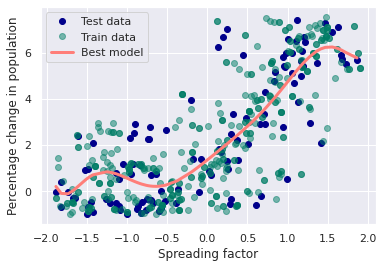

In [11]:
lists = sorted(zip(*[x_test, y_test_pred]))
sorted_x_test, sorted_y_test_pred = list(zip(*lists))

plt.plot(x_test,y_test,'o',color='darkblue', label="Test data")
plt.plot(x_train.values,y_train,'o',color="#007D66", alpha=0.5,label="Train data")
plt.xlabel('Spreading factor')
plt.ylabel('Percentage change in population')
plt.plot(sorted_x_test,sorted_y_test_pred,color='#FF7E79',linewidth=3, label="Best model")
plt.legend()
plt.show()

### 

<h4>3.1</h4>
<b>Find the best hyper-parameter alpha.<b>

In [12]:
# Parameters
alpha_list = [1e-4, 1e-3, 1e-2,1e-1,1]
numboot = 10
max_degree = 30

In [13]:
# Find the best regularisation coefficient
warnings.filterwarnings('ignore')
mse_list = []

for alpha in alpha_list:
    x_train = newdf[['Spreading_factor']]
    x_poly_train = PolynomialFeatures(max_degree).fit_transform(x_train)
    y_train = newdf.Perc_population
    lasso = Lasso(fit_intercept=False, alpha=alpha, max_iter = 100000)
    mse_score = cross_validate(lasso, x_poly_train, y_train, cv=10, scoring = 'neg_mean_squared_error')
    mean_mse = np.mean(-mse_score['test_score'])
    mse_list.append(mean_mse)

best_alpha = alpha_list[mse_list.index(min(mse_list))]

print(f'The best alpha value is {best_alpha}')

The best alpha value is 0.01


<h4> 3.2 </h4> <b> Find the most significant degrees. <b>

In [14]:
warnings.filterwarnings('ignore')
significant_degrees = {}
for i in range(numboot):
    newdf = df_train.sample(frac=1,replace=True)
    x_train = newdf[['Spreading_factor']]
    x_poly_train = PolynomialFeatures(30).fit_transform(x_train)
    y_train = newdf.Perc_population

    lasso = Lasso(fit_intercept=False,max_iter = 20000, alpha=best_alpha)
    lasso.fit(x_poly_train, y_train)
    for i in np.where(np.abs(lasso.coef_>0.1))[0]:

        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

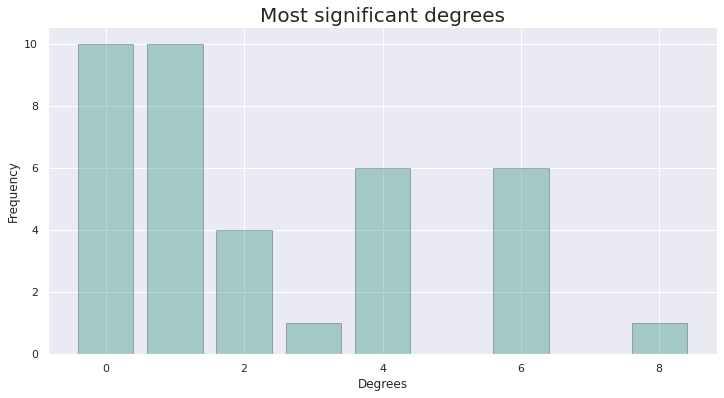

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

lists = sorted(significant_degrees.items())

x,y = zip(*lists)

ax.bar(x,y,color = '#007D66',alpha=0.3,edgecolor='k')
ax.set_xlabel('Degrees')
ax.set_ylabel('Frequency')
ax.set_title('Most significant degrees',fontsize = 20)

sns.despine()

<h4> 3.3  </h4> <b> Compute the MSE on the test set <b>

In [16]:
best_deg = 4

x_poly_train = PolynomialFeatures(best_deg).fit_transform(x_train)
x_poly_test = PolynomialFeatures(best_deg).fit_transform(x_test)
lasso = Lasso(max_iter=20000, alpha = best_alpha, fit_intercept= False)

lasso.fit(x_poly_train,y_train)
y_test_pred = lasso.predict(x_poly_test)
mse = mean_squared_error(y_test, y_test_pred)
print("The MSE of the best model is",mse)

The MSE of the best model is 2.591980930384191


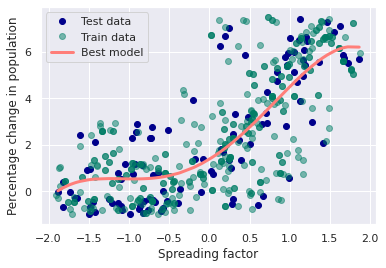

In [17]:
lists = sorted(zip(*[x_test, y_test_pred]))
sorted_x_test, sorted_y_test_pred = list(zip(*lists))

plt.plot(x_test,y_test,'o',color='darkblue', label="Test data")
plt.plot(x_train.values,y_train,'o',color="#007D66", alpha=0.5,label="Train data")
plt.xlabel('Spreading factor')
plt.ylabel('Percentage change in population')
plt.plot(sorted_x_test,sorted_y_test_pred,color='#FF7E79',linewidth=3, label="Best model")
plt.legend()
plt.show()

<h4> 3.4 </h4> <b> What are your observations? <b>

<b> a) Is the best_degree computed above more consistent over the bootstraps? Why? <b>

The best degree is not consistent owing once again to the stochasticity in the choice of bootstraps which might give unexpected results. 

<b> b) Which degree coefficients in your best fit model from above are significant? Why only some? <b>

The coefficients that are significant are of degrees 0, 1, 4, 5, 6.

<b> c) Is your test  𝑀𝑆𝐸  with regularisation comparable to the findings from previous section. If more, or less, by how much? <b>

The test MSEs in the two cases are comparable. However the later is slightly lower. 

<b> d) Is your current model more reliable? On what basis do you claim its robustness? <b>

Yes, the current model is more reliable as bootstrapping shows similar results. This is justified by the fact that we have obtained lower test MSE using this degree 4 curve than the previous degree 8 curve.

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
<h2 style="color:black;background-color:#EFF8D0"> Part B: Racial bias in machine learning systems</h2> <a class="anchor" id="partB"></a>

### [70 points] 
    
![](https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/opener-b-crop-2400*1350-00796e.jpg)

<br />
<b> Dataset Description </b><br />
    
The main dataset is the `compas.csv` <br />
ProPublica's analysis is publically available [here](https://github.com/propublica/compas-analysis).

The dataset was made publically available by **Northpointe**, an American tech-company that works with law establishment across several states in the US to predict future crimes based on past records of criminals.

It has been suspected that the software used by Northpointe, `COMPAS`, is biased against the african american criminals, who end up with `high-risk` tags, despite minor criminal record, whereas `Caucasians` regularly received low-scores despite more significant criminal charges.
    
After pressure from several news agencies and a public investigation by ProPublica, the company released this dataset with a slice of the factors usually considered in order to assign a score to criminals.
<br /><br />
The dataset also contains a column `two_year_recid` with a binary response, i.e `1` if the released criminal ended up committing another crime within two years and `0` if the criminal did not commit a crime within a period of two years.
    
To learn more about this dataset, and the public investigation, you are highly recommended to read ProPublica's article on [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)

<h4>1.1</h4>
<b>
Split the data into 80% training and 20% validation sets stratified by race.

By Stratified we mean that the two sets should have roughly similar distribution of races as the original data. For more information on how to stratify using sklearn, check sklearn documentation here.
<br />
</b>    
**Note:** Before splitting you may want to process the categorical predictors first so you don't have to do it separately in train and validation later.

In [18]:
# Get the data
df = pd.read_csv('data/compas.csv')

#Splitting the races
aa_df = df[df['race'] == 'African-American']
cc_df = df[df['race'] == 'Caucasian']

df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,...,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,50,M,arrest case no charge,Caucasian,Medium,0,30,0,0,0,...,0,0,1,0,0,0,0,0,0,4
1,28,M,Susp Drivers Lic 1st Offense,African-American,Medium,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,F,Aggravated Assault W/dead Weap,Other,Low,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,5
3,25,F,Burglary Unoccupied Dwelling,Hispanic,Medium,0,14,0,1,2,...,0,0,1,0,1,1,0,0,1,1
4,34,F,Possession of Cannabis,African-American,Medium,1,7,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [19]:
# One hot encode
one_hot_df = pd.get_dummies(df,columns = columns=['c_charge_degree', "race"], prefix=['c_charge_degree', "race"], drop_first = True)

# columns of interest
cols = df.select_dtypes(include=np.number).columns.tolist()
df_race = pd.concat([df[cols], one_hot_df], axis=1)

## Splitting the data

data_train, data_val = train_test_split(df_race, train_size = 0.8, stratify = df['race'], random_state = 109)
y_train, X_train = data_train.two_year_recid, data_train.drop(['two_year_recid'], axis=1)
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid'], axis=1)

<h4>1.2</h4>
<b>Can you guess why processing the categorical predictors is important? What is the risk of processing categorical predictors after splitting into train and validation sets?

We process the categorical predictors before splitting to make sure that we don't lose some categories due to the split. If this happens we might not have any encoding for a particular value the categorical variable takes.

<h4>1.3 </h4>
<b>
Make overlapping distributions (histograms) of the following predictors for two groups, African American & Caucasian.
- Age
- Priors count
- Sex
- Length of stay


[Text(0.5, 1.0, 'Histogram showing overlapping distribution of age for African-American and Caucasian.')]

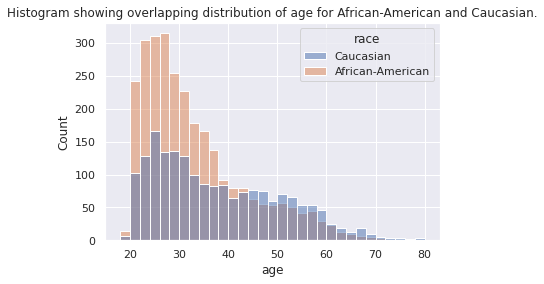

In [22]:
## Suggested Change

#Histogram showing overlapping distribution of age for African-American and Caucasian.
df_af_c = df[df.race.isin(["Caucasian", "African-American"])]
sns.histplot(x='age', data = df_af_c, hue='race').set(title = 'Histogram showing overlapping distribution of age for African-American and Caucasian.')

[Text(0.5, 1.0, 'Histogram showing overlapping distribution of priors count for African-American and Caucasian.')]

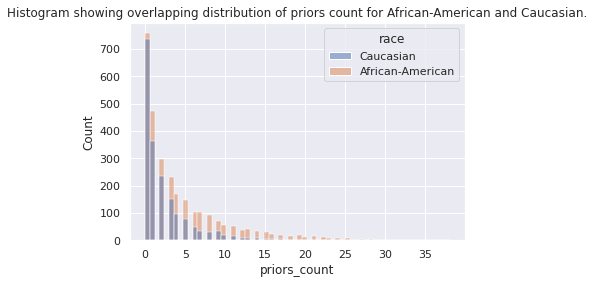

In [23]:
#Histogram showing overlapping distribution of priors count for African-American and Caucasian.
sns.histplot(x='priors_count', data = df_af_c, hue='race').set(title = 'Histogram showing overlapping distribution of priors count for African-American and Caucasian.')

[Text(0.5, 1.0, 'Histogram showing overlapping distribution of sex for African-American and Caucasian.')]

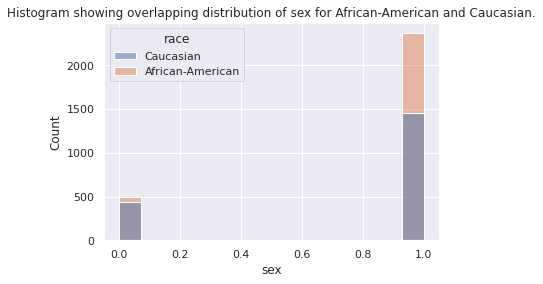

In [24]:
#Histogram showing overlapping distribution of sex for African-American and Caucasian.
sns.histplot(x='sex', data = df_af_c, hue='race').set(title = 'Histogram showing overlapping distribution of sex for African-American and Caucasian.')

[Text(0.5, 1.0, 'Histogram showing overlapping distribution of length of stay for African-American and Caucasian.')]

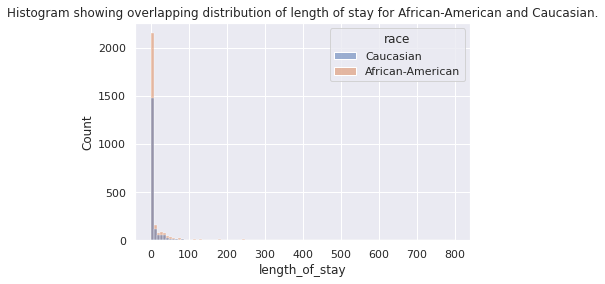

In [25]:
#Histogram showing overlapping distribution of length of stay for African-American and Caucasian.
sns.histplot(x='length_of_stay', data = df_af_c, hue="race", bins= 100).set(title = 'Histogram showing overlapping distribution of length of stay for African-American and Caucasian.')

The previous plot is too cramped to be interpreted in one plot, so we decided to split the graph by length of stay values - 0 to 20, 20 to 400 and 400 to 800 so that the patterns in the graph are more clearly visible.

[(0.0, 20.0),
 Text(0.5, 1.0, 'Histogram showing overlapping distribution of length of stay for African-American and Caucasian(length of stay = 0 to 20).')]

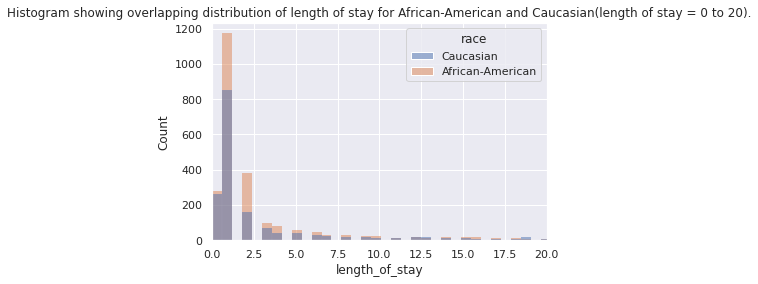

In [26]:
#Histogram showing overlapping distribution of length of stay for African-American and Caucasian(length of stay = 0 to 20).
sns.histplot(x='length_of_stay', data = df_af_c, hue="race").set(xlim=(0, 20),title = 'Histogram showing overlapping distribution of length of stay for African-American and Caucasian(length of stay = 0 to 20).')

[(20.0, 400.0),
 (0.0, 20.0),
 Text(0.5, 1.0, 'Histogram showing overlapping distribution of length of stay for African-American and Caucasian(length of stay = 20 to 400).')]

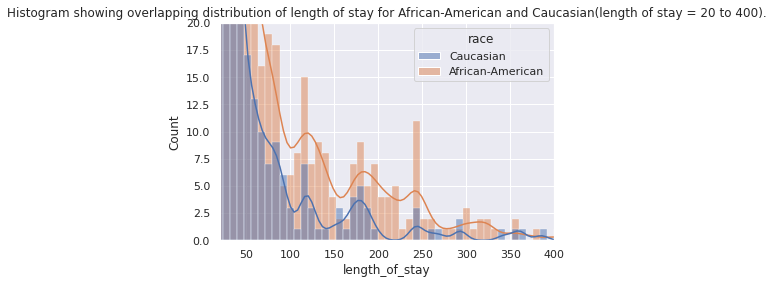

In [27]:
#Histogram showing overlapping distribution of length of stay for African-American and Caucasian(length of stay = 20 to 400).
sns.histplot(x='length_of_stay', data = df_af_c, hue="race", kde=True, bins=100).set(xlim=(20, 400), ylim=(0, 20),title = 'Histogram showing overlapping distribution of length of stay for African-American and Caucasian(length of stay = 20 to 400).')

<h4>1.4</h4>
<b> 
Among the following variables, which ones show disparity between the two groups? Explain your results in 2-3 sentences.

Priors count and age are the 2 variables that shows disparity. <br>
Age: In the younger brackets, we have more of African-American and in the older age bracket, we seem to have more of Caucasian.
Prior Count: African americans seems to have more prior counts in general according to the data.

<h4>2.1</h4>
<b> 
Build a logistic regression model to predict recidivism (two_year_recid) on these data and be sure to include race as a predictor.

In [28]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)

print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)}')

 Training set accuracy = 0.7 
 validation set accuracy = 0.68


In [29]:
# Separating the races 
X_val = X_val.reset_index(drop='True')

aa_ind = np.array(X_val[(X_val['race_Asian'] == 0) & (X_val['race_Caucasian'] == 0) 
                & (X_val['race_Other'] == 0) & (X_val['race_Native American'] == 0)].index.tolist())

cc_ind = np.array(X_val[X_val['race_Caucasian'] == 1].index.tolist())

In [30]:
aa_fplist = []
cc_fplist = []
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)

print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x,"\n\n")

print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')

print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

African Americans
[[221 104]
 [107 231]]
Caucasians
[[185  59]
 [ 69  65]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |        32.0       |   24.18    |
| False -ves % |       31.66       |   51.49    |
+--------------+-------------------+------------+ 


African Americans 1.3x more likely to be falsely flagged compared to Caucasians
Caucasians 1.6x more likely to be mislabeled as low risk compared to African Americans


<h4>2.2</h4>
<b>
What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.

Yes, African-Americans are substantially more likely to be falsely labelled as positive, than Caussians <br>
On the other hand, Caucasians are much more likely to be falsely labelled as negative, than African-Americans which compliments the first point

<h4>3.1</h4>
<b>
Refit the logistic model in 2.1 but this time without race as a predictor. 

In [31]:
# Not to include 'race' as a predictor 

data_train, data_val = train_test_split(df[cols], train_size = 0.8, stratify = df['race'], random_state=109)
y_train, X_train = data_train.two_year_recid, data_train.drop(['two_year_recid'], axis=1)
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid'], axis=1)

In [32]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)
print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)} \n\n')
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)
print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x,"\n\n")
print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')
print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

 Training set accuracy = 0.7 
 validation set accuracy = 0.68 


African Americans
[[220 105]
 [105 233]]
Caucasians
[[190  54]
 [ 71  63]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |       32.31       |   22.13    |
| False -ves % |       31.07       |   52.99    |
+--------------+-------------------+------------+ 


African Americans 1.5x more likely to be falsely flagged compared to Caucasians
Caucasians 1.7x more likely to be mislabeled as low risk compared to African Americans


<h4> 3.2 </h4>
<b>
Now, without the race as a predictor, what do you observe?

We observe more or less the same results whem race is not included as a predictor. This is due to the proxy variables that are indirectly affected by race. 

<h4>3.3</h4>
<b>How do these compare to the model when the race is included as a predictor?

The results are almost the same. 

<h4>3.4</h4>
<b>Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.


The bias still occurs. The disparity is an inherent property of the dataset itself and is not due to using race as a predictor.

<h4>4.1</h4>
<b>
Use logistic regression from above and plot the Receiver Operating Characteristic curve for two races, African Americans & Caucasians.

In [33]:
# Get the data
df = pd.read_csv('data/compas.csv')

#Splitting the races
aa_df = df[df['race'] == 'African-American']
cc_df = df[df['race'] == 'Caucasian']

df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,...,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,50,M,arrest case no charge,Caucasian,Medium,0,30,0,0,0,...,0,0,1,0,0,0,0,0,0,4
1,28,M,Susp Drivers Lic 1st Offense,African-American,Medium,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,F,Aggravated Assault W/dead Weap,Other,Low,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,5
3,25,F,Burglary Unoccupied Dwelling,Hispanic,Medium,0,14,0,1,2,...,0,0,1,0,1,1,0,0,1,1
4,34,F,Possession of Cannabis,African-American,Medium,1,7,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [34]:
# One hot encode
one_hot_df = pd.get_dummies(df['race'], prefix='race', drop_first = True)

# columns of interest
cols = df.select_dtypes(include=np.number).columns.tolist()
df_race = pd.concat([df[cols], one_hot_df], axis=1)

## Splitting the data

data_train, data_val = train_test_split(df_race, train_size = 0.8, stratify = df['race'], random_state = 109)
y_train, X_train = data_train.two_year_recid, data_train.drop(['two_year_recid'], axis=1)
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid'], axis=1)

In [35]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)

print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)}')

 Training set accuracy = 0.7 
 validation set accuracy = 0.68


In [36]:
# Separating the races 
X_val = X_val.reset_index(drop='True')

aa_ind = np.array(X_val[(X_val['race_Asian'] == 0) & (X_val['race_Caucasian'] == 0) 
                & (X_val['race_Other'] == 0) & (X_val['race_Native American'] == 0)].index.tolist())

cc_ind = np.array(X_val[X_val['race_Caucasian'] == 1].index.tolist())

In [37]:
aa_fplist = []
cc_fplist = []
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)

print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x)

print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')

print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

African Americans
[[221 104]
 [107 231]]
Caucasians
[[185  59]
 [ 69  65]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |        32.0       |   24.18    |
| False -ves % |       31.66       |   51.49    |
+--------------+-------------------+------------+
African Americans 1.3x more likely to be falsely flagged compared to Caucasians
Caucasians 1.6x more likely to be mislabeled as low risk compared to African Americans


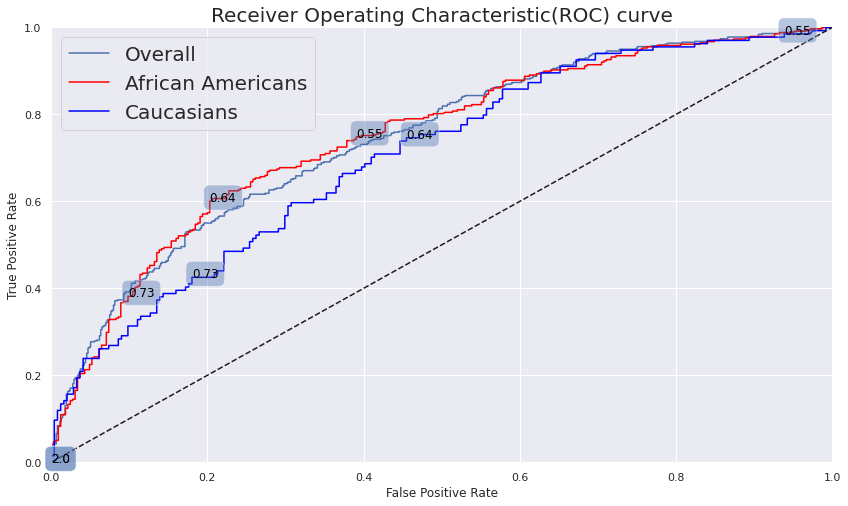

In [38]:
# Probabilities
yprobs = logreg.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, yprobs)


# aa_ind african americans
# cc_ind caucasians


aa_fpr, aa_tpr, aa_thresholds = roc_curve(y_val.values[aa_ind],yprobs[aa_ind])
cc_fpr, cc_tpr, cc_thresholds = roc_curve(y_val.values[cc_ind],yprobs[cc_ind])

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(fpr,tpr,color = 'b', label = 'Overall')
ax.plot(aa_fpr, aa_tpr, color = 'red',label = 'African Americans')
ax.plot(cc_fpr, cc_tpr, color = 'blue',label = 'Caucasians')
ax.plot([0,1],[0,1],'k--')

label_kwargs = {}
label_kwargs['bbox'] = dict(boxstyle = 'round, pad = 0.5', alpha =0.4)


n_fpr = fpr.shape[0]

for k in range(0,200,50):
    threshold = str(np.round(thresholds[k],2))
    ax.annotate(threshold, (aa_fpr[k],aa_tpr[k]), color = 'black', **label_kwargs)
    ax.annotate(threshold, (cc_fpr[k],cc_tpr[k]), color = 'black', **label_kwargs)
   
    
# Aesthetics

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic(ROC) curve',fontsize = 20)
ax.legend(loc='best',fontsize=20)
sns.despine()

<h4>4.2</h4>
<b>
How to ensure the model is accurate and unbiased? Please keep your answers short (300 word limit)

Choose a threshold where the bias is the least. <br>
Do not confuse the closeness of the 2 curves with an absence of bias. To get an indication of the bias, we need to choose the same threshold and find the corresponding False Positive rate and True Positive Rate for each race.

**5.1**
**Build a Decision Tree model and find the best depth**

In [39]:
data_train, data_val = train_test_split(df_race, train_size = 0.8, stratify = df['race'], random_state = 109)
y_train, X_train = data_train.two_year_recid, data_train.drop(['two_year_recid'], axis=1)
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid'], axis=1)

In [40]:
#Find optimal depth of trees
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 1, 10, 1
for i in range(tree_depth_start, tree_depth_end + 1, steps):
    
    #declare tree model object
    model = DecisionTreeClassifier(max_depth=i)
    
    #get cv scores
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    
    all_CV_acc[i] = scores
    mean_CV_acc[i] = scores.mean()

In [41]:
x = list(mean_CV_acc.keys())
y = list(mean_CV_acc.values())
x,y

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0.6554038853251452,
  0.6637324050709876,
  0.6779117137384854,
  0.6794885436617719,
  0.6754375297682385,
  0.6772395849167503,
  0.6682391896958826,
  0.6630590095157024,
  0.6603575735465499,
  0.6531546732334135])

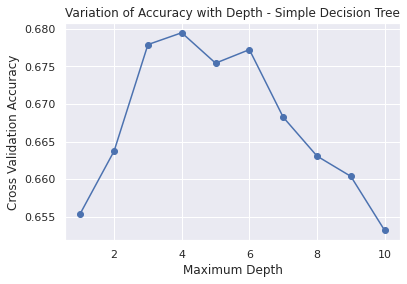

In [42]:
#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

In [45]:
#Make best depth a variable
best_depth = sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)[0]
print("The best depth was found to be:", best_depth)

The best depth was found to be: 4


In [46]:
#Evaluate the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(X_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set
acc_trees_training = accuracy_score(y_train, model_tree.predict(X_train))
acc_trees_validation  = accuracy_score(y_val,  model_tree.predict(X_val))

print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_validation))

Simple Decision Trees: Accuracy, Training Set 	 : 69.64%
Simple Decision Trees: Accuracy, Testing Set 	 : 67.24%


In [47]:
tree.export_graphviz(model_tree, "example_tree2.dot")
#import pydot
(graph,) = pydot.graph_from_dot_file("example_tree2.dot")

graph.write_png('tree.png')

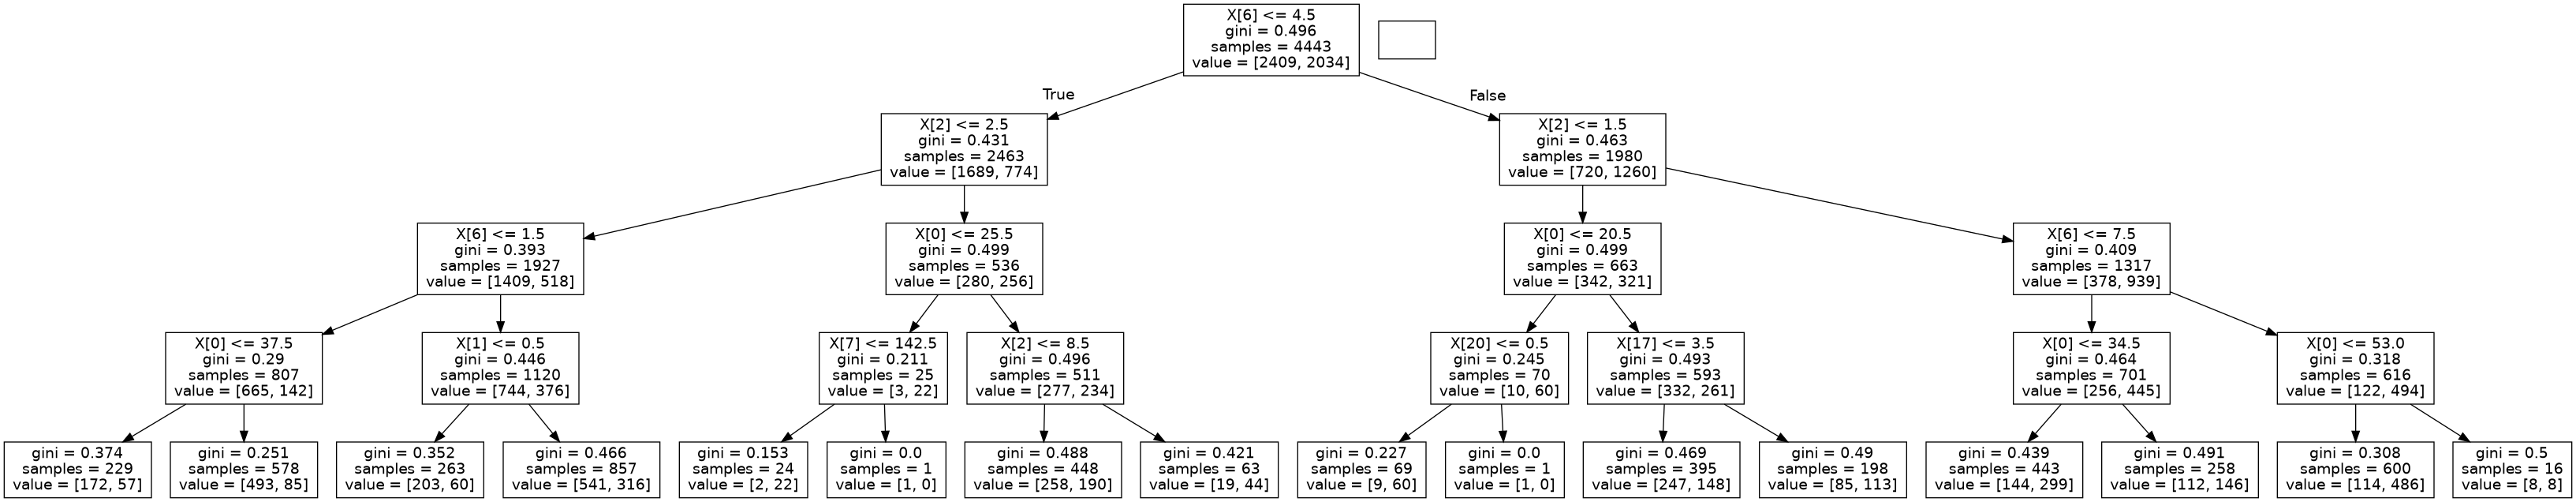

In [48]:
from IPython.display import Image
Image("tree.png")

**5.2** **What difference do you notice in the model performance?**

Ans.

In [49]:
#upsampling

In [50]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

data_train, data_val = train_test_split(df[cols + ['race']], train_size = 0.8, stratify = df['race'], random_state=109)

os = SMOTE(random_state= 109)
os_data_X, os_data_y = os.fit_resample(data_train[cols],data_train['race'])
os_data_X = pd.DataFrame(os_data_X, columns = ['age', 'sex', 'priors_count', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'decile_score', 'two_year_recid', 'length_of_stay',
       'priors_1', 'priors_234', 'priors_5plus', 'juv_fel_1plus',
       'juv_misd_1plus', 'juv_other_1plus', 'charge_any_drug',
       'charge_any_violence_aggression', 'charge_any_theft',
       'length_of_stay_thresh'])
os_data_y = pd.DataFrame(os_data_y, columns=['race'])
# predictors and response

X_train, y_train = os_data_X.drop(['two_year_recid'],axis=1), os_data_X.two_year_recid
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid', 'race'], axis=1)

In [51]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)
print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)} \n\n')
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)
print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x,"\n\n")
print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')
print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

 Training set accuracy = 0.81 
 validation set accuracy = 0.67 


African Americans
[[258  67]
 [158 180]]
Caucasians
[[212  32]
 [ 89  45]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |       20.62       |   13.11    |
| False -ves % |       46.75       |   66.42    |
+--------------+-------------------+------------+ 


African Americans 1.6x more likely to be falsely flagged compared to Caucasians
Caucasians 1.4x more likely to be mislabeled as low risk compared to African Americans


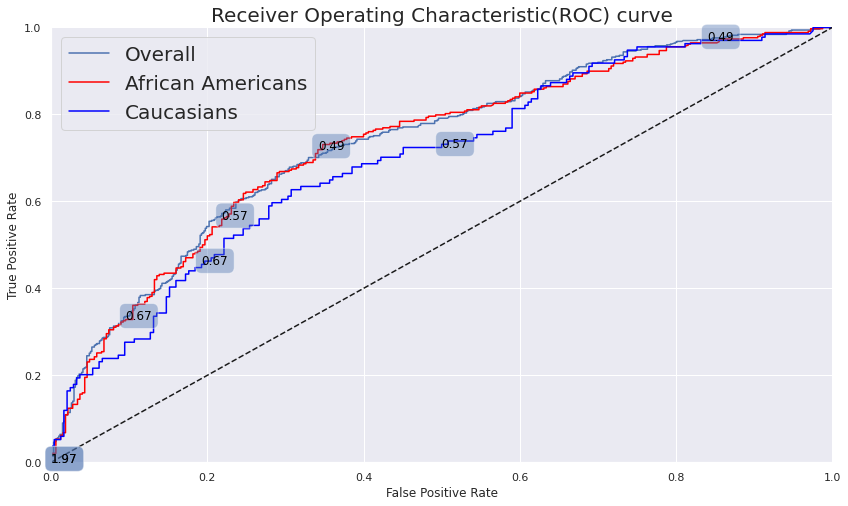

In [52]:
# Probabilities
yprobs = logreg.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, yprobs)


# aa_ind african americans
# cc_ind caucasians


aa_fpr, aa_tpr, aa_thresholds = roc_curve(y_val.values[aa_ind],yprobs[aa_ind])
cc_fpr, cc_tpr, cc_thresholds = roc_curve(y_val.values[cc_ind],yprobs[cc_ind])

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(fpr,tpr,color = 'b', label = 'Overall')
ax.plot(aa_fpr, aa_tpr, color = 'red',label = 'African Americans')
ax.plot(cc_fpr, cc_tpr, color = 'blue',label = 'Caucasians')


ax.plot([0,1],[0,1],'k--')

label_kwargs = {}
label_kwargs['bbox'] = dict(boxstyle = 'round, pad = 0.5', alpha =0.4)


n_fpr = fpr.shape[0]

for k in range(0,200,50):
    threshold = str(np.round(thresholds[k],2))
    ax.annotate(threshold, (aa_fpr[k],aa_tpr[k]), color = 'black', **label_kwargs)
    ax.annotate(threshold, (cc_fpr[k],cc_tpr[k]), color = 'black', **label_kwargs)
   
    
# Aesthetics

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic(ROC) curve',fontsize = 20)
ax.legend(loc='best',fontsize=20)
sns.despine()

In [53]:
thresholds.shape

(477,)

In [54]:
threshdict = {}
thresholds = np.linspace(0,1,101)
for i in thresholds:
    ypred_val = [1 if prob >= i else 0 for prob in yprobs]
    aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind]) 
    cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
    fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
    round(accuracy_score(y_val, ypred_val),2)
    threshdict[i] = [fp_aa,fp_cc,100*round(accuracy_score(y_val, ypred_val),2)]

In [55]:
thresh_data = list(threshdict.values())
thresh_fp_aa, thresh_fp_cc, thresh_acc = [i[0] for i in thresh_data],[i[1] for i in thresh_data],[i[2] for i in thresh_data]

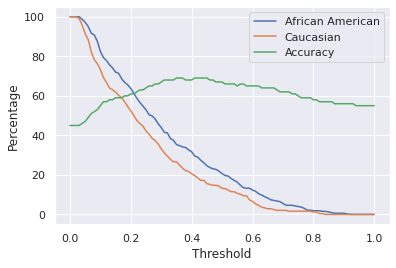

In [56]:
fig,ax = plt.subplots()
ax.plot(list(threshdict.keys()),thresh_fp_aa,label = 'African American')
ax.plot(list(threshdict.keys()),thresh_fp_cc,label = 'Caucasian')
ax.plot(list(threshdict.keys()),thresh_acc,label = 'Accuracy')
ax.set_xlabel("Threshold")
ax.set_ylabel("Percentage")
ax.legend();

In [57]:
def bca(acc,x,y):  
    x=np.array(x)
    y=np.array(y)
    acc=np.array(acc)
    return acc - np.absolute(x-y)

In [58]:
bca_list=bca(thresh_acc,thresh_fp_aa,thresh_fp_cc)

In [59]:
bca_ind=np.argmax(bca_list)
best_thresh=thresholds[bca_ind]
print("Best threshold is", round(best_thresh,4)," with a BCA of", bca_list[bca_ind])
print("The corresponding accuracy is ", threshdict[best_thresh][2], "and the FPR for African Americans and Caucasians are", threshdict[best_thresh][0],"and",threshdict[best_thresh][1]," respectively.")

Best threshold is 0.57  with a BCA of 61.89
The corresponding accuracy is  66.0 and the FPR for African Americans and Caucasians are 13.54 and 9.43  respectively.
